# Loading Data


# Step 1: Import Required Library




In [ ]:

import pandas as pd

# Step 2: Load All Datasets
### customer_data  → Contains customer details
### order_data     → Contains order details for each transaction
### store_data     → Contains store location information

In [ ]:
data=pd.read_csv('/content/customer_data.csv')
order_data=pd.read_csv('/content/order_data.csv')
store_data=pd.read_csv('/content/store_data.csv')

# Step 3: Verify Data Shapes
### Printing the shape of each dataset to understand:
###  - Number of rows (observations)
###  - Number of columns (features)
### This helps confirm successful loading and gives an idea of dataset size

In [ ]:
print(order_data.shape)
print(store_data.shape)
print(data.shape)

(1414410, 8)
(38, 4)
(563346, 2)


## Merging files

 Step 1: Remove duplicate keys to avoid unintended joins

 Step 2: Merge customer type into order data

 Step 3: Merge store information into the combined data

In [ ]:
# Step 1: Remove duplicate keys to avoid unintended joins
# CUSTOMER_ID → unique for each customer
# STORE_NUMBER → unique for each store
customer_data = data.drop_duplicates(subset='CUSTOMER_ID')
store_data = store_data.drop_duplicates(subset='STORE_NUMBER')

# Step 2: Merge customer type into order data
# Common column: CUSTOMER_ID
# This adds customer type information to each order
df = order_data.merge(customer_data, on='CUSTOMER_ID', how='left')

# Step 3: Merge store information into the combined data
# Common column: STORE_NUMBER
# This adds store location details (city, state, postal code) to each order
df = df.merge(store_data, on='STORE_NUMBER', how='left')


print("Original order rows:", order_data.shape[0])
print("Merged rows:", df.shape[0])

Original order rows: 1414410
Merged rows: 1414410


### Final shape of merged dataframe

In [ ]:

df.shape

(1414410, 12)

## Fill missing values

# Step 1: Check for missing values in each column
### This shows how many null/NaN values are present per column

In [ ]:

df.isnull().sum()

CUSTOMER_ID                   0
STORE_NUMBER                  0
ORDER_CREATED_DATE            0
ORDER_ID                      0
ORDERS                        0
ORDER_CHANNEL_NAME            0
ORDER_SUBCHANNEL_NAME         0
ORDER_OCCASION_NAME           0
CUSTOMER_TYPE                59
CITY                     512196
STATE                    557621
POSTAL_CODE               93648
dtype: int64

# Step 2: Remove rows where CUSTOMER_TYPE is missing
### CUSTOMER_TYPE is important for personalization, so rows without it cannot be used

In [ ]:

df = df.dropna(subset=['CUSTOMER_TYPE'])

In [ ]:
def bi_directional_imputation(df):
    # Convert columns to string type for consistency during mapping
    df['POSTAL_CODE'] = df['POSTAL_CODE'].astype(str)
    df['CITY'] = df['CITY'].astype(str)
    df['STATE'] = df['STATE'].astype(str)

    # 1. Fill CITY using POSTAL_CODE
    # For each POSTAL_CODE, find the most common CITY and map it to missing CITY values
    postal_code_to_city = (
        df.dropna(subset=['POSTAL_CODE', 'CITY'])
          .groupby('POSTAL_CODE')['CITY']
          .agg(lambda x: x.mode().iloc[0])
          .to_dict()
    )
    df.loc[df['CITY'].isna(), 'CITY'] = df.loc[df['CITY'].isna(), 'POSTAL_CODE'].map(postal_code_to_city)

    # 2. Fill STATE using POSTAL_CODE
    # For each POSTAL_CODE, find the most common STATE and map it to missing STATE values
    postal_code_to_state = (
        df.dropna(subset=['POSTAL_CODE', 'STATE'])
          .groupby('POSTAL_CODE')['STATE']
          .agg(lambda x: x.mode().iloc[0])
          .to_dict()
    )
    df.loc[df['STATE'].isna(), 'STATE'] = df.loc[df['STATE'].isna(), 'STORE_NUMBER'].map(postal_code_to_state)

    # 3. Fill POSTAL_CODE using CITY
    # For each CITY, find the most common POSTAL_CODE and map it to missing POSTAL_CODE values
    city_to_postal_code = (
        df.dropna(subset=['CITY', 'POSTAL_CODE'])
          .groupby('CITY')['POSTAL_CODE']
          .agg(lambda x: x.mode().iloc[0])
          .to_dict()
    )
    df.loc[df['POSTAL_CODE'].isna(), 'POSTAL_CODE'] = df.loc[df['POSTAL_CODE'].isna(), 'CITY'].map(city_to_postal_code)

    # 4. Fill any remaining missing values with defaults
    # 'Unknown' for CITY and STATE, '0000' for POSTAL_CODE
    df['CITY'] = df['CITY'].fillna('Unknown')
    df['STATE'] = df['STATE'].fillna('Unknown')
    df['POSTAL_CODE'] = df['POSTAL_CODE'].fillna('0000')

    return df

In [ ]:
# Apply the bi-directional imputation function
# This fills missing CITY, STATE, and POSTAL_CODE values using cross-mapping logic
df = bi_directional_imputation(df)

In [ ]:
# Check the number of missing values in each column after imputation
# This helps confirm that our missing value handling was successful
df.isnull().sum()

CUSTOMER_ID              0
STORE_NUMBER             0
ORDER_CREATED_DATE       0
ORDER_ID                 0
ORDERS                   0
ORDER_CHANNEL_NAME       0
ORDER_SUBCHANNEL_NAME    0
ORDER_OCCASION_NAME      0
CUSTOMER_TYPE            0
CITY                     0
STATE                    0
POSTAL_CODE              0
dtype: int64

# EDA

## Understand Data Structure

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1414351 entries, 0 to 1414409
Data columns (total 12 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   CUSTOMER_ID            1414351 non-null  int64 
 1   STORE_NUMBER           1414351 non-null  int64 
 2   ORDER_CREATED_DATE     1414351 non-null  object
 3   ORDER_ID               1414351 non-null  int64 
 4   ORDERS                 1414351 non-null  object
 5   ORDER_CHANNEL_NAME     1414351 non-null  object
 6   ORDER_SUBCHANNEL_NAME  1414351 non-null  object
 7   ORDER_OCCASION_NAME    1414351 non-null  object
 8   CUSTOMER_TYPE          1414351 non-null  object
 9   CITY                   1414351 non-null  object
 10  STATE                  1414351 non-null  object
 11  POSTAL_CODE            1414351 non-null  object
dtypes: int64(3), object(9)
memory usage: 140.3+ MB


In [ ]:
df.describe(include='all')

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,CUSTOMER_ID,STORE_NUMBER,ORDER_CREATED_DATE,ORDER_ID,ORDERS,ORDER_CHANNEL_NAME,ORDER_SUBCHANNEL_NAME,ORDER_OCCASION_NAME,CUSTOMER_TYPE,CITY,STATE,POSTAL_CODE
count,1.414351e+06,1.414351e+06,1414351,1.414351e+06,1414351,1414351,1414351,1414351,1414351,1414351,1414351,1414351
unique,NaN,NaN,446,NaN,735502,1,2,2,5,22,11,37
top,NaN,NaN,2025-03-25,NaN,"{""orders"": [{""item_details"": [{""item_name"": ""2...",Digital,WWT,ToGo,Registered,nan,nan,nan
freq,NaN,NaN,11860,NaN,33654,1414351,1411030,1214877,1140068,512189,557613,93646
mean,4.999720e+08,2.406045e+03,NaN,5.001032e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,2.885240e+08,1.455202e+03,NaN,2.887703e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.588000e+03,2.660000e+02,NaN,1.904200e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2.503520e+08,1.161000e+03,NaN,2.498403e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,5.010237e+08,2.156000e+03,NaN,4.997313e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,7.492328e+08,4.065000e+03,NaN,7.503652e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Parse the ORDER column

ORDERS column contains a JSON-like string

In [ ]:
import pandas as pd
import json

# Function to extract all item names
def extract_items(order_str):
    try:
        data = json.loads(order_str)
        items = []
        for order in data.get("orders", []):
            for item in order.get("item_details", []):
                items.append(item.get("item_name", "").strip())
        return items
    except:
        return []

# Apply to your DataFrame
df['ALL_ITEMS'] = df['ORDERS'].apply(extract_items)

In [ ]:
df

,CUSTOMER_ID,STORE_NUMBER,ORDER_CREATED_DATE,ORDER_ID,ORDERS,ORDER_CHANNEL_NAME,ORDER_SUBCHANNEL_NAME,ORDER_OCCASION_NAME,CUSTOMER_TYPE,CITY,STATE,POSTAL_CODE,ALL_ITEMS
0,362204699,2156,2024-07-24,7247194287,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo,Registered,GRAPEVINE,TX,76051,"[Order Memo Not Paid, 10 pc Grilled Wings Comb..."
1,269612955,1419,2025-02-15,791214421,"{""orders"": [{""item_details"": [{""item_name"": ""R...",Digital,WWT,ToGo,Registered,HUNTERSVILLE,NC,28078,"[Ranch Dip - Regular, 50 pc Grilled Wings, Reg..."
2,585330633,2249,2025-02-15,7575285208,"{""orders"": [{""item_details"": [{""item_name"": ""2...",Digital,WWT,ToGo,Guest,nan,nan,32792,"[20pc Spicy Feast Deal, Order Memo Paid]"
3,950661333,2513,2024-03-29,4253875716,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo,Registered,LAS VEGAS,NV,89129,"[Order Memo Item, Order Memo Paid, 20 pc Grill..."
4,434985772,1754,2024-04-08,7150407872,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo,Guest,ARDMORE,OK,73401,"[Order Blankline 2, 6 pc Grilled Wings Combo, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1414405,125634365,4595,2025-02-02,762304305,"{""orders"": [{""item_details"": [{""item_name"": ""1...",Digital,WWT,ToGo,Guest,CHARLOTTE,NC,28208,"[10 pc Spicy Wings Combo, Order Memo Paid]"
1414406,125634365,1419,2025-01-22,9371418183,"{""orders"": [{""item_details"": [{""item_name"": ""C...",Digital,WWT,ToGo,Guest,HUNTERSVILLE,NC,28078,"[Chicken Sub, Add 5 Spicy Wings, Ranch Dip - R..."
1414407,125634365,4595,2025-02-13,8082200700,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo,Guest,CHARLOTTE,NC,28208,"[Order Memo Paid, 4 pc Crispy Strips]"
1414408,125634365,1419,2024-11-30,8865782702,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo,Guest,HUNTERSVILLE,NC,28078,"[Order Memo Paid, Chicken Sub Combo]"


Print all different types of items in order to see if theere are some

---

discrepencies

In [ ]:
import pandas as pd
import json

# Assuming your DataFrame is named df and the 'ORDERS' column is in JSON format

unique_items = set()

for order_str in df['ORDERS'].dropna():
    try:
        data = json.loads(order_str)
        for order in data.get('orders', []):
            for item in order.get('item_details', []):
                name = item.get('item_name', '').strip()
                if name:
                    unique_items.add(name)
    except:
        continue

# Print sorted list of unique item names
for item in sorted(unique_items):
    print(item)


$19.99 Crispy Feast
10 pc Grilled Wings
10 pc Grilled Wings Combo
10 pc Mixed Wings
10 pc Mixed Wings Combo
10 pc Spicy Wings
10 pc Spicy Wings Combo
100 pc Family Grilled Wings
100 pc Family Mixed Wings
100 pc Family Spicy Wings
100 pc Grilled Wings
100 pc Mixed Wings
100 pc Spicy Wings
15 pc Crispy Strips
15 pc Grilled Wings
15 pc Grilled Wings Combo
15 pc Mixed Wings
15 pc Mixed Wings Combo
15 pc Spicy Wings
15 pc Spicy Wings Combo
2 pc Crispy Strips
20 Oz Soda
20 pc Crispy Strips
20 pc Grilled Wings
20 pc Mixed Wings
20 pc Spicy Wings
20pc Spicy Feast Deal
24 pc Family Grilled Wings
24 pc Family Mixed Wings
24 pc Family Spicy Wings
25 pc Game Day Pack
25 pc Spicy Wings
3 Strips Lunch
3 pc Crispy Strips Combo
3 pc Grilled Wings
30 pc Crispy Strips
30 pc Family Grilled Wings
30 pc Family Mixed Wings
30 pc Family Spicy Wings
30 pc Grilled Wings
30 pc Mixed Wings
30 pc Spicy Wings
32 Oz Soda
3pc Strips Box
4 pc Crispy Strips
40 pc Family Grilled Wings
40 pc Family Mixed Wings
40 pc Fam

### Clean All_ITEMS column

Typically, we want to keep food and drink items that customers can intentionally choose to eat or drink, and remove:

Order notes / memos

Packaging / utensils

Delivery fees / upgrades

Dips and sauces (optional, unless they are frequently ordered as main sides)

Order placeholders or blank lines

Items clearly meant for internal handling or logistics



In [ ]:
non_recommendable_items = {
    'Order Memo ASAP', 'Order Memo Future', 'Order Memo Item', 'Order Memo Not Paid', 'Order Memo Paid',
    'Plastic Fork', 'Plastic Knife', 'Plastic Straw', 'Plastic Utensils', 'Ketchup Pack', 'Seasoning Pack',
    'Drink Upgrade', 'Extra Sauce', 'Dipping Sauce', 'Delivery Fee', 'Domestic Draft Lager', 'Domestic Lager',
    'Premium Lager', 'Order Blankline 1', 'Order Blankline 2'
}

# Filter out non-recommendable items from the 'orders' list
df['ALL_ITEMS'] = df['ALL_ITEMS'].apply(lambda x: [item for item in x if item not in non_recommendable_items])


In [ ]:
df

,CUSTOMER_ID,STORE_NUMBER,ORDER_CREATED_DATE,ORDER_ID,ORDERS,ORDER_CHANNEL_NAME,ORDER_SUBCHANNEL_NAME,ORDER_OCCASION_NAME,CUSTOMER_TYPE,CITY,STATE,POSTAL_CODE,ALL_ITEMS
0,362204699,2156,2024-07-24,7247194287,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo,Registered,GRAPEVINE,TX,76051,"[10 pc Grilled Wings Combo, 8 pc Grilled Wings..."
1,269612955,1419,2025-02-15,791214421,"{""orders"": [{""item_details"": [{""item_name"": ""R...",Digital,WWT,ToGo,Registered,HUNTERSVILLE,NC,28078,"[Ranch Dip - Regular, 50 pc Grilled Wings, Reg..."
2,585330633,2249,2025-02-15,7575285208,"{""orders"": [{""item_details"": [{""item_name"": ""2...",Digital,WWT,ToGo,Guest,nan,nan,32792,[20pc Spicy Feast Deal]
3,950661333,2513,2024-03-29,4253875716,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo,Registered,LAS VEGAS,NV,89129,"[20 pc Grilled Wings, Ranch Dip - Regular]"
4,434985772,1754,2024-04-08,7150407872,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo,Guest,ARDMORE,OK,73401,"[6 pc Grilled Wings Combo, 8 pc Grilled Wings ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1414405,125634365,4595,2025-02-02,762304305,"{""orders"": [{""item_details"": [{""item_name"": ""1...",Digital,WWT,ToGo,Guest,CHARLOTTE,NC,28208,[10 pc Spicy Wings Combo]
1414406,125634365,1419,2025-01-22,9371418183,"{""orders"": [{""item_details"": [{""item_name"": ""C...",Digital,WWT,ToGo,Guest,HUNTERSVILLE,NC,28078,"[Chicken Sub, Add 5 Spicy Wings, Ranch Dip - R..."
1414407,125634365,4595,2025-02-13,8082200700,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo,Guest,CHARLOTTE,NC,28208,[4 pc Crispy Strips]
1414408,125634365,1419,2024-11-30,8865782702,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo,Guest,HUNTERSVILLE,NC,28078,[Chicken Sub Combo]


In [ ]:
# Assuming df is already loaded
# Convert ALL_ITEMS from string to list (if stored as string)
df['ALL_ITEMS'] = df['ALL_ITEMS'].apply(lambda x: literal_eval(x) if isinstance(x, str) else x)

# Explode list into separate rows
df_exploded = df.explode('ALL_ITEMS')

# Group to find counts
item_counts = df_exploded.groupby(['STATE', 'ALL_ITEMS']).size().reset_index(name='count')


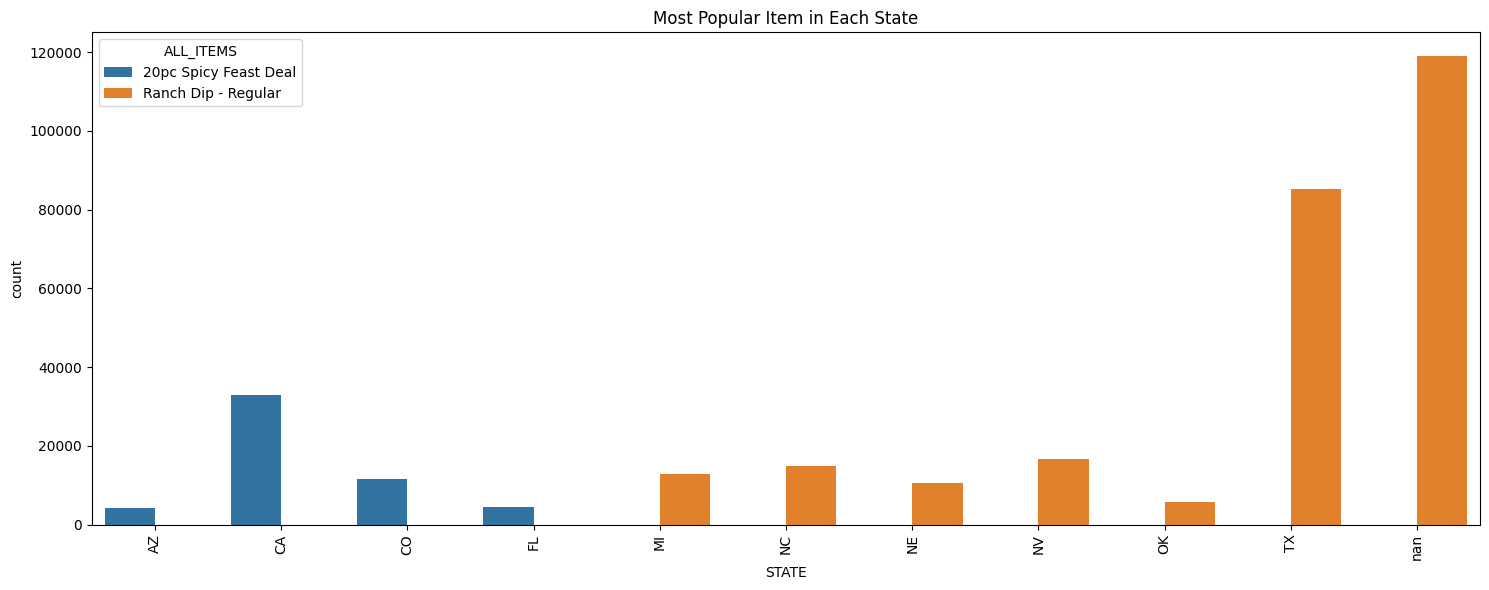

<Figure size 640x480 with 0 Axes>

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# 1Plot: Most popular item per state (bar plot)
top_items_per_state = item_counts.loc[item_counts.groupby('STATE')['count'].idxmax()]
plt.figure(figsize=(15, 6))
sns.barplot(data=top_items_per_state, x='STATE', y='count', hue='ALL_ITEMS')
plt.title('Most Popular Item in Each State')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
plt.savefig("plot11.png")


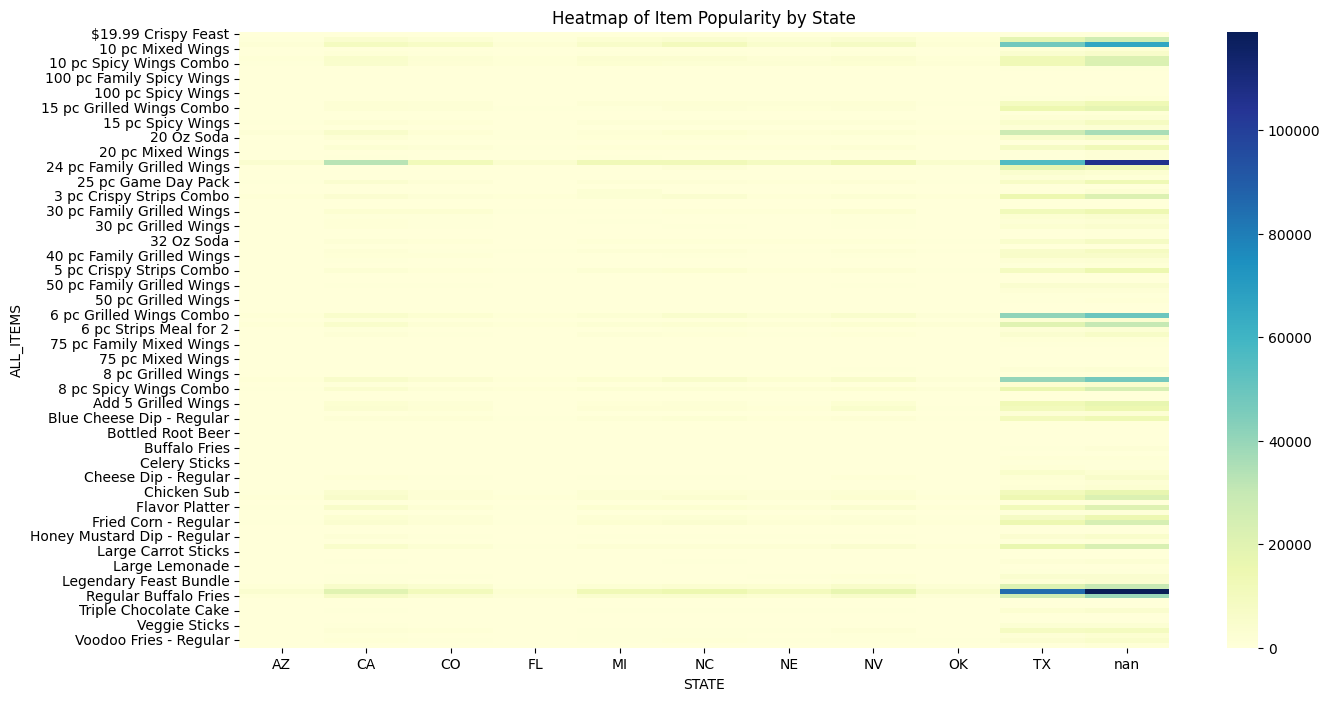

<Figure size 640x480 with 0 Axes>

In [ ]:
# 2 Plot: Heatmap of item popularity by state
pivot_table = item_counts.pivot(index='ALL_ITEMS', columns='STATE', values='count').fillna(0)
plt.figure(figsize=(15, 8))
sns.heatmap(pivot_table, cmap='YlGnBu')
plt.title('Heatmap of Item Popularity by State')
plt.show()

plt.savefig("plot4.png")


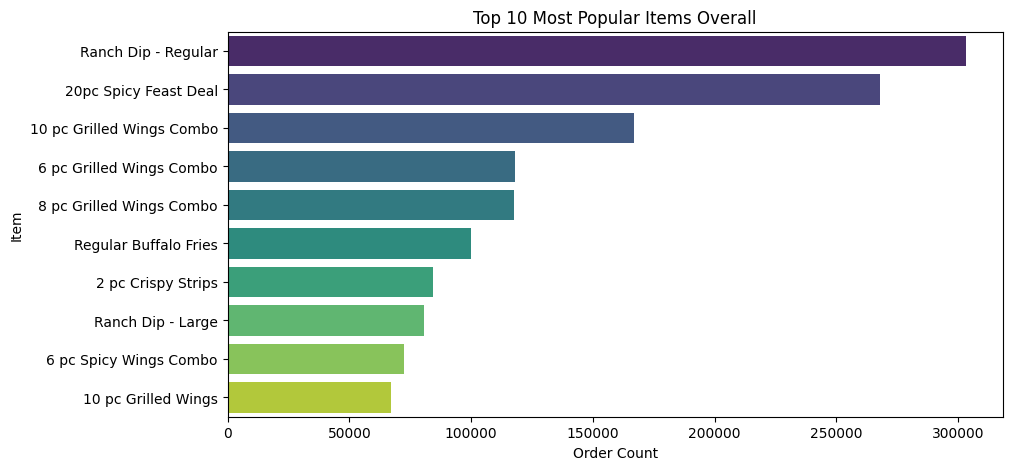

<Figure size 640x480 with 0 Axes>

In [ ]:
# 3️Plot: Top N most popular items overall
top_items = df_exploded['ALL_ITEMS'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_items.values, y=top_items.index, palette='viridis')
plt.title('Top 10 Most Popular Items Overall')
plt.xlabel('Order Count')
plt.ylabel('Item')
plt.show()

plt.savefig("plot6.png")

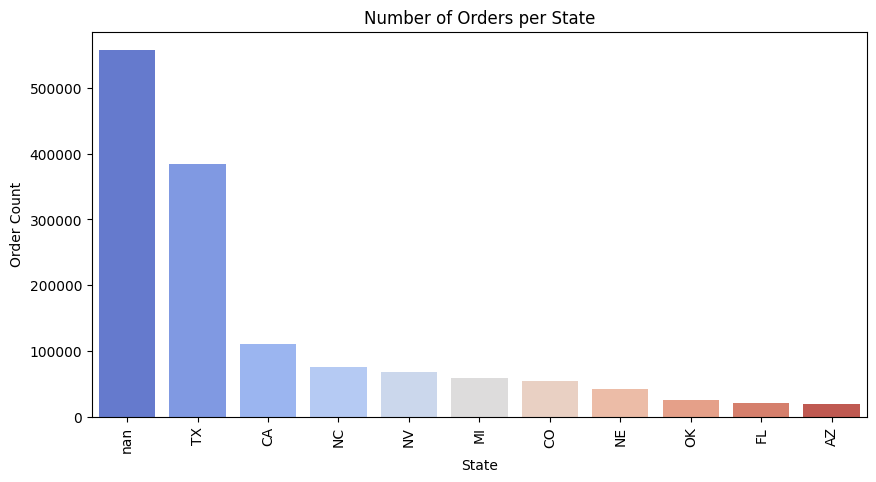

<Figure size 640x480 with 0 Axes>

In [ ]:
# 4 Plot: Distribution of orders per state
state_counts = df['STATE'].value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=state_counts.index, y=state_counts.values, palette='coolwarm')
plt.title('Number of Orders per State')
plt.xlabel('State')
plt.ylabel('Order Count')
plt.xticks(rotation=90)
plt.show()

plt.savefig("plot7.png")

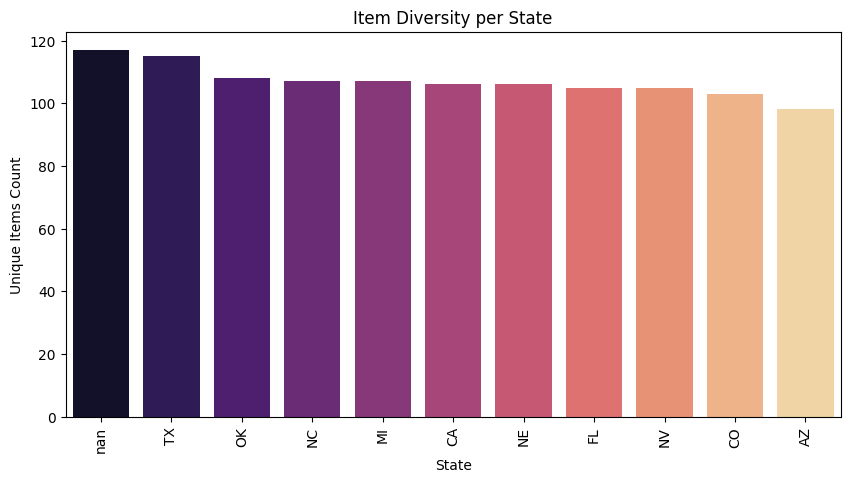

<Figure size 640x480 with 0 Axes>

In [ ]:
# 5️ Plot: Item diversity per state (number of unique items)
unique_items_per_state = df_exploded.groupby('STATE')['ALL_ITEMS'].nunique().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=unique_items_per_state.index, y=unique_items_per_state.values, palette='magma')
plt.title('Item Diversity per State')
plt.xlabel('State')
plt.ylabel('Unique Items Count')
plt.xticks(rotation=90)
plt.show()

plt.savefig("plot8.png")

## Temporal Pattern

In [ ]:
df['ORDER_CREATED_DATE'] = pd.to_datetime(df['ORDER_CREATED_DATE'])
df['DAY_OF_WEEK'] = df['ORDER_CREATED_DATE'].dt.dayofweek
df['ORDER_MONTH'] = df['ORDER_CREATED_DATE'].dt.month
df['ORDER_HOUR'] = df['ORDER_CREATED_DATE'].dt.hour  # if timestamp available


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


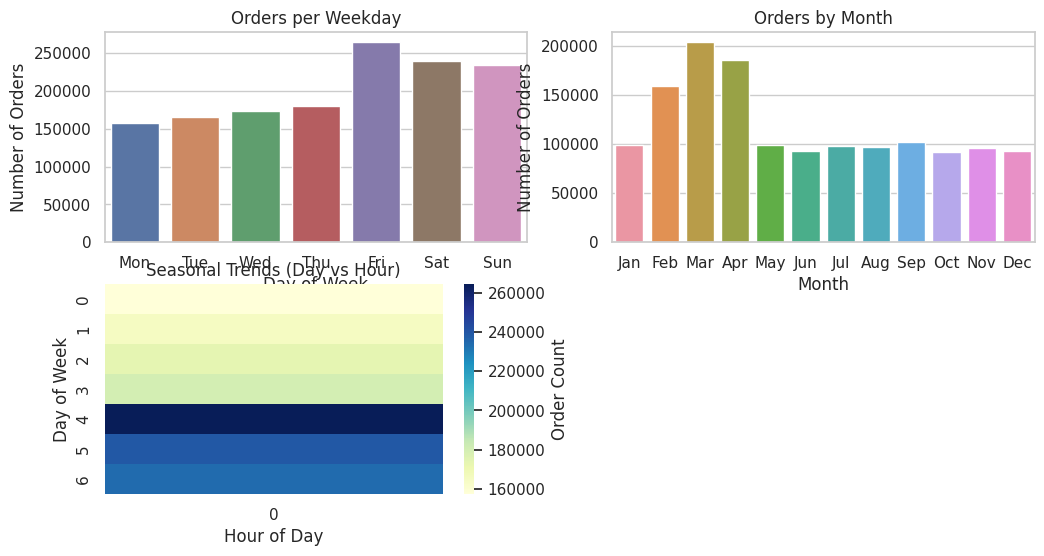

In [ ]:

# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# 1. Orders per weekday
plt.subplot(2, 2, 1)
weekday_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
orders_weekday = df['DAY_OF_WEEK'].value_counts().sort_index()
sns.barplot(x=weekday_order, y=orders_weekday.values)
plt.title('Orders per Weekday')
plt.xlabel('Day of Week')
plt.ylabel('Number of Orders')
plt.savefig("plot.png")

# 2. Orders by month
plt.subplot(2, 2, 2)
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
orders_month =df['ORDER_MONTH'].value_counts().sort_index()
sns.barplot(x=month_order, y=orders_month.values)
plt.title('Orders by Month')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.savefig("plot.png")

# 3. Seasonal trends (heatmap: hour vs day)
plt.subplot(2, 2, 3)
heatmap_data = df.groupby(['DAY_OF_WEEK', 'ORDER_HOUR']).size().unstack(fill_value=0)
sns.heatmap(heatmap_data, cmap='YlGnBu', cbar_kws={'label': 'Order Count'})
plt.title('Seasonal Trends (Day vs Hour)')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.savefig("plot.png")




/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


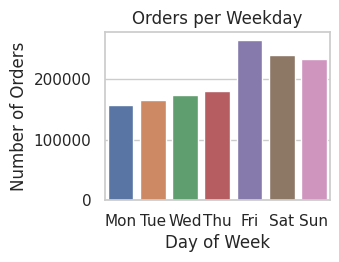

In [ ]:
# 1. Orders per weekday
plt.subplot(2, 2, 2)
weekday_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
orders_weekday = df['DAY_OF_WEEK'].value_counts().sort_index()
sns.barplot(x=weekday_order, y=orders_weekday.values)
plt.title('Orders per Weekday')
plt.xlabel('Day of Week')
plt.ylabel('Number of Orders')
plt.savefig("plot2.png")

### Extract item1 item2 item3 and target from all items

necessary for training

In [ ]:
import random
import numpy as np

# Initialize new columns
df['item1'] = None
df['item2'] = None
df['item3'] = None
df['target'] = None

for index, items in df['ALL_ITEMS'].items():
    num_items = len(items)

    if num_items >= 4:
        selected = random.sample(items, 4)
        input_items = selected[:3]
        target_item = selected[3]

    elif num_items == 3:
        input_items = items[:2]
        target_item = items[2]

    elif num_items == 2:
        input_items = [items[0]]
        target_item = items[1]

    elif num_items == 1:
        input_items = []
        target_item = items[0]

    else:
        input_items = []
        target_item = None

    # Assign input items to columns, fill missing with None
    df.loc[index, 'item1'] = input_items[0] if len(input_items) > 0 else None
    df.loc[index, 'item2'] = input_items[1] if len(input_items) > 1 else None
    df.loc[index, 'item3'] = input_items[2] if len(input_items) > 2 else None
    df.loc[index, 'target'] = target_item


In [ ]:
df.isnull().sum()

CUSTOMER_ID                    0
STORE_NUMBER                   0
ORDER_CREATED_DATE             0
ORDER_ID                       0
ORDERS                         0
ORDER_CHANNEL_NAME             0
ORDER_SUBCHANNEL_NAME          0
ORDER_OCCASION_NAME            0
CUSTOMER_TYPE                  0
CITY                           0
STATE                          0
POSTAL_CODE                    0
ALL_ITEMS                      0
DAY_OF_WEEK                    0
ORDER_MONTH                    0
ORDER_HOUR                     0
item1                     610905
item2                    1054829
item3                    1281345
target                        88
dtype: int64

Drop row where target is null

In [ ]:
df = df.dropna(subset=['target'])
# Fill missing values
df = df.fillna('Unknown')

# Model Training

## XGB classifier

In [ ]:
df

,CUSTOMER_ID,STORE_NUMBER,ORDER_CREATED_DATE,ORDER_ID,ORDERS,ORDER_CHANNEL_NAME,ORDER_SUBCHANNEL_NAME,ORDER_OCCASION_NAME,CUSTOMER_TYPE,CITY,STATE,POSTAL_CODE,ALL_ITEMS,DAY_OF_WEEK,ORDER_MONTH,ORDER_HOUR,item1,item2,item3,target
0,362204699,2156,2024-07-24,7247194287,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo,Registered,GRAPEVINE,TX,76051,"[10 pc Grilled Wings Combo, 8 pc Grilled Wings...",2,7,0,10 pc Grilled Wings Combo,8 pc Grilled Wings Combo,Unknown,8 pc Spicy Wings Combo
1,269612955,1419,2025-02-15,791214421,"{""orders"": [{""item_details"": [{""item_name"": ""R...",Digital,WWT,ToGo,Registered,HUNTERSVILLE,NC,28078,"[Ranch Dip - Regular, 50 pc Grilled Wings, Reg...",5,2,0,Ranch Dip - Regular,50 pc Grilled Wings,Unknown,Regular Buffalo Fries
2,585330633,2249,2025-02-15,7575285208,"{""orders"": [{""item_details"": [{""item_name"": ""2...",Digital,WWT,ToGo,Guest,nan,nan,32792,[20pc Spicy Feast Deal],5,2,0,Unknown,Unknown,Unknown,20pc Spicy Feast Deal
3,950661333,2513,2024-03-29,4253875716,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo,Registered,LAS VEGAS,NV,89129,"[20 pc Grilled Wings, Ranch Dip - Regular]",4,3,0,20 pc Grilled Wings,Unknown,Unknown,Ranch Dip - Regular
4,434985772,1754,2024-04-08,7150407872,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo,Guest,ARDMORE,OK,73401,"[6 pc Grilled Wings Combo, 8 pc Grilled Wings ...",0,4,0,6 pc Grilled Wings Combo,Unknown,Unknown,8 pc Grilled Wings Combo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1414405,125634365,4595,2025-02-02,762304305,"{""orders"": [{""item_details"": [{""item_name"": ""1...",Digital,WWT,ToGo,Guest,CHARLOTTE,NC,28208,[10 pc Spicy Wings Combo],6,2,0,Unknown,Unknown,Unknown,10 pc Spicy Wings Combo
1414406,125634365,1419,2025-01-22,9371418183,"{""orders"": [{""item_details"": [{""item_name"": ""C...",Digital,WWT,ToGo,Guest,HUNTERSVILLE,NC,28078,"[Chicken Sub, Add 5 Spicy Wings, Ranch Dip - R...",2,1,0,Chicken Sub,Add 5 Spicy Wings,Unknown,Ranch Dip - Regular
1414407,125634365,4595,2025-02-13,8082200700,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo,Guest,CHARLOTTE,NC,28208,[4 pc Crispy Strips],3,2,0,Unknown,Unknown,Unknown,4 pc Crispy Strips
1414408,125634365,1419,2024-11-30,8865782702,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo,Guest,HUNTERSVILLE,NC,28078,[Chicken Sub Combo],5,11,0,Unknown,Unknown,Unknown,Chicken Sub Combo


In [ ]:
# Save DataFrame to CSV

df.to_csv("df.csv", index=False)

print(" Files saved as train_df.csv and df.csv")


 Files saved as train_df.csv and df.csv


Importing required libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import recall_score
from xgboost import XGBClassifier

Filter data on basis of target data we can only validate on that data point on whic traing has been done else it will show error hence we use only that target point whose frequency is more then or equal to 2

In [ ]:
# Count occurrences per class
class_counts = df['target'].value_counts()

# Keep only classes with at least 2 samples
valid_classes = class_counts[class_counts >= 2].index

# Filter data
df = df[df['target'].isin(valid_classes)].copy()


convert to category type

In [ ]:
# Convert POSTAL_CODE to categorical type
df['POSTAL_CODE'] = df['POSTAL_CODE'].astype('category')

# Convert POSTAL_CODE to categorical type
df['ORDER_OCCASION_NAME'] = df['ORDER_OCCASION_NAME'].astype('category')



### Encode target labels and item columns into numeric form
 LabelEncoder maps each unique category to an integer starting from 0


In [ ]:

#  Encode target labels to consecutive integers
label_encoder = LabelEncoder()
df['target'] = label_encoder.fit_transform(df['target'])

df['item1'] = label_encoder.fit_transform(df['item1'])


df['item2'] = label_encoder.fit_transform(df['item2'])

df['item3'] = label_encoder.fit_transform(df['item3'])




In [ ]:
import joblib
# Save during training
joblib.dump(label_encoder, "label_encoder.pkl")

['label_encoder.pkl']

Convert categorical features from object type to category type

In [ ]:

# Convert object columns to category, handling list values
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].apply(lambda x: tuple(x) if isinstance(x, list) else x)
    df[col] = df[col].astype('category')


In [ ]:
# Split features and labels
X = df.drop(['target','ALL_ITEMS','ORDER_ID','ORDERS','ORDER_CREATED_DATE','CITY','STATE','POSTAL_CODE','DAY_OF_WEEK','ORDER_MONTH','ORDER_HOUR'], axis=1)
y = df['target']

In [ ]:
X

,CUSTOMER_ID,STORE_NUMBER,ORDER_CHANNEL_NAME,ORDER_SUBCHANNEL_NAME,ORDER_OCCASION_NAME,CUSTOMER_TYPE,item1,item2,item3
0,362204699,2156,Digital,WWT,ToGo,Registered,2,68,110
1,269612955,1419,Digital,WWT,ToGo,Registered,110,53,110
2,585330633,2249,Digital,WWT,ToGo,Guest,117,112,110
3,950661333,2513,Digital,WWT,ToGo,Registered,23,112,110
4,434985772,1754,Digital,WWT,ToGo,Guest,56,112,110
...,...,...,...,...,...,...,...,...,...
1414405,125634365,4595,Digital,WWT,ToGo,Guest,117,112,110
1414406,125634365,1419,Digital,WWT,ToGo,Guest,91,74,110
1414407,125634365,4595,Digital,WWT,ToGo,Guest,117,112,110
1414408,125634365,1419,Digital,WWT,ToGo,Guest,117,112,110


In [ ]:
#  Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


### Model initialization along with hyper parameters tuning

In [ ]:
# Step 9: XGBoost model training
model1 = XGBClassifier(
    objective='multi:softprob',
    tree_method='hist',
    device='cuda',
    num_class=len(np.unique(y_train)), # Set num_class based on unique values in y_train
    learning_rate=0.01,
    max_depth=8,
    n_estimators=4000,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,                  # Minimum loss reduction for split
    min_child_weight=3,       # Minimum sum of instance weight needed in a child
    reg_alpha=0.01,           # L1 regularization term on weights
    reg_lambda=1,             # L2 regularization term on weights
    eval_metric='mlogloss',
    early_stopping_rounds=20,
    use_label_encoder=False,
    verbosity=1,
    n_jobs=-1,
    enable_categorical=True # Enable categorical feature support
)


### Model Training

In [ ]:

model1.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=True
    )


[0]	validation_0-mlogloss:4.74892	validation_1-mlogloss:4.74905
[1]	validation_0-mlogloss:4.70640	validation_1-mlogloss:4.70682
[2]	validation_0-mlogloss:4.67025	validation_1-mlogloss:4.67095
[3]	validation_0-mlogloss:4.64242	validation_1-mlogloss:4.64332
[4]	validation_0-mlogloss:4.60893	validation_1-mlogloss:4.61007
[5]	validation_0-mlogloss:4.57883	validation_1-mlogloss:4.58021
[6]	validation_0-mlogloss:4.55305	validation_1-mlogloss:4.55464
[7]	validation_0-mlogloss:4.52612	validation_1-mlogloss:4.52794
[8]	validation_0-mlogloss:4.50429	validation_1-mlogloss:4.50631
[9]	validation_0-mlogloss:4.47947	validation_1-mlogloss:4.48173
[10]	validation_0-mlogloss:4.45563	validation_1-mlogloss:4.45811
[11]	validation_0-mlogloss:4.43334	validation_1-mlogloss:4.43607
[12]	validation_0-mlogloss:4.41394	validation_1-mlogloss:4.41687
[13]	validation_0-mlogloss:4.39308	validation_1-mlogloss:4.39621
[14]	validation_0-mlogloss:4.37350	validation_1-mlogloss:4.37683
[15]	validation_0-mlogloss:4.35423	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device='cuda', early_stopping_rounds=20,
              enable_categorical=True, eval_metric='mlogloss',
              feature_types=None, gamma=1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=4000,
              n_jobs=-1, num_class=120, num_parallel_tree=None, ...)

# Validation

In [ ]:
#  Predict top 3 items
y_pred_probs = model1.predict_proba(X_test)
top_3_preds = np.argsort(y_pred_probs, axis=1)[:, -3:][:, ::-1]  # Top 3 predictions in order


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:24:17] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Reset index of y_true if it's a pandas Series/DataFrame
if isinstance(y_test, (pd.Series, pd.DataFrame)):
    y_true = y_test.reset_index(drop=True)

# Ensure top_3_preds is a list of lists or a NumPy array
top_3_preds = np.array(top_3_preds)

# Calculate custom Top-3 Recall: 1 if any predicted class matches the true class
recall_at_3 = np.mean([
    y_test.iloc[i] in top_3_preds[i] if isinstance(top_3_preds[i], (list, np.ndarray)) else False
    for i in range(len(y_test))
])

print(f"Top-3 Recall (any match): {recall_at_3:.4f}")

Top-3 Recall (any match): 0.4159


In [ ]:
# Save DataFrame to CSV

df.to_csv("df.csv", index=False)

print(" Files saved as train_df.csv and df.csv")


In [ ]:
import pandas as pd

# Model Prediction on test dataset

In [ ]:
test_df=pd.read_csv('/kaggle/input/test-dataset/test_data_question.csv')

In [ ]:
test_df

,CUSTOMER_ID,STORE_NUMBER,ORDER_ID,ORDER_CHANNEL_NAME,ORDER_SUBCHANNEL_NAME,ORDER_OCCASION_NAME,CUSTOMER_TYPE,item1,item2,item3
0,997177535,4915,9351345556,Digital,WWT,ToGo,Guest,Chicken Sub Combo,Ranch Dip - Regular,10 pc Spicy Wings Combo
1,345593831,949,3595377080,Digital,WWT,ToGo,Registered,Regular Buffalo Fries,10 pc Spicy Wings,3 pc Crispy Strips Combo
2,160955031,2249,4071757785,Digital,WWT,ToGo,Guest,Large Buffalo Fries,10 pc Spicy Wings,Ranch Dip - Regular
3,890671991,4154,3931766769,Digital,WWT,ToGo,Guest,6 pc Grilled Wings Combo,20 pc Grilled Wings,Fried Corn - Large
4,73989021,4094,3739700809,Digital,WWT,ToGo,Registered,Regular Buffalo Fries,20 pc Grilled Wings,Ranch Dip - Large
...,...,...,...,...,...,...,...,...,...,...
995,199551661,4915,5790578362,Digital,WWT,Delivery,Registered,Chicken Sub Combo,10 pc Grilled Wings,Chicken Sub
996,324907688,1161,371107248,Digital,WWT,ToGo,Guest,10 pc Grilled Wings Combo,Veggie Sticks Spicy,8 pc Grilled Wings Combo
997,688871063,949,7519184133,Digital,WWT,ToGo,Registered,Fried Corn - Regular,Flavor Platter,Ranch Dip - Regular
998,529892223,4750,8800902863,Digital,WWT,Delivery,Registered,Regular Buffalo Fries,Ranch Dip - Regular,Legendary Feast Bundle


In [ ]:
df1 = test_df.drop(columns=['ORDER_ID'])


In [ ]:
df1.isnull().sum()

CUSTOMER_ID              0
STORE_NUMBER             0
ORDER_CHANNEL_NAME       0
ORDER_SUBCHANNEL_NAME    0
ORDER_OCCASION_NAME      0
CUSTOMER_TYPE            0
item1                    0
item2                    0
item3                    0
dtype: int64

In [ ]:

# Convert POSTAL_CODE to categorical type
test_df['ORDER_OCCASION_NAME'] = test_df['ORDER_OCCASION_NAME'].astype('category')




In [ ]:

#  Encode target labels to consecutive integers


df1['item1'] = label_encoder.fit_transform(df1['item1'])


df1['item2'] = label_encoder.fit_transform(df1['item2'])

df1['item3'] = label_encoder.fit_transform(df1['item3'])




In [ ]:

# Convert object columns to category, handling list values
for col in df1.select_dtypes(include=['object']).columns:
    df1[col] = df1[col].apply(lambda x: tuple(x) if isinstance(x, list) else x)
    df1[col] = df1[col].astype('category')


Prediction on test_data and outpit should only contain those classes which were present in traing data encoder

In [ ]:
# Valid class indices from training
valid_classes = np.arange(len(label_encoder.classes_))  # numeric IDs of classes

In [ ]:
# Model prediction probabilities
y_proba = model1.predict_proba(df1)

# Mask out any invalid classes (if model somehow predicts an unseen index)
mask = np.full_like(y_proba, -np.inf)
mask[:, valid_classes] = y_proba[:, valid_classes]  # keep only valid classes


In [ ]:
# Get top 3 predictions
top3_indices = np.argsort(mask, axis=1)[:, -3:][:, ::-1]  # top 3 in descending order

In [ ]:


# Decode to original item labels
top3_labels = np.vectorize(lambda idx: label_encoder.inverse_transform([idx])[0])(top3_indices)

print(top3_labels)


[['32 Oz Soda' 'Voodoo Fries - Large' '8 pc Spicy Wings Combo']
 ['Chicken Sub Combo' 'Large Veggie Sticks Spicy' '15 pc Grilled Wings']
 ['Voodoo Fries - Large' '30 pc Family Grilled Wings'
  '3 pc Crispy Strips Combo']
 ...
 ['3 pc Crispy Strips Combo' '10 pc Mixed Wings'
  'Blue Cheese Dip - Regular']
 ['Chicken Sub' '10 pc Mixed Wings' 'Dipping Sauce']
 ['3 pc Crispy Strips Combo' 'Chicken Sub' 'Dipping Sauce']]


In [ ]:
# Convert to 3 separate 1D arrays
pred1 = top3_labels[:, 0]  # First column
pred2 = top3_labels[:, 1]  # Second column
pred3 = top3_labels[:, 2]  # Third column


In [ ]:
# Add top 3 predictions as new columns in test_df
test_df["pred1"] = pred1
test_df["pred2"] = pred2
test_df["pred3"] = pred3


In [ ]:
test_df

,CUSTOMER_ID,STORE_NUMBER,ORDER_ID,ORDER_CHANNEL_NAME,ORDER_SUBCHANNEL_NAME,ORDER_OCCASION_NAME,CUSTOMER_TYPE,item1,item2,item3,pred1,pred2,pred3
0,997177535,4915,9351345556,Digital,WWT,ToGo,Guest,Chicken Sub Combo,Ranch Dip - Regular,10 pc Spicy Wings Combo,32 Oz Soda,Voodoo Fries - Large,8 pc Spicy Wings Combo
1,345593831,949,3595377080,Digital,WWT,ToGo,Registered,Regular Buffalo Fries,10 pc Spicy Wings,3 pc Crispy Strips Combo,Chicken Sub Combo,Large Veggie Sticks Spicy,15 pc Grilled Wings
2,160955031,2249,4071757785,Digital,WWT,ToGo,Guest,Large Buffalo Fries,10 pc Spicy Wings,Ranch Dip - Regular,Voodoo Fries - Large,30 pc Family Grilled Wings,3 pc Crispy Strips Combo
3,890671991,4154,3931766769,Digital,WWT,ToGo,Guest,6 pc Grilled Wings Combo,20 pc Grilled Wings,Fried Corn - Large,3 pc Crispy Strips Combo,Voodoo Fries - Large,8 pc Spicy Wings Combo
4,73989021,4094,3739700809,Digital,WWT,ToGo,Registered,Regular Buffalo Fries,20 pc Grilled Wings,Ranch Dip - Large,Chicken Sub,Voodoo Fries - Large,10 pc Mixed Wings
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,199551661,4915,5790578362,Digital,WWT,Delivery,Registered,Chicken Sub Combo,10 pc Grilled Wings,Chicken Sub,Voodoo Fries - Large,8 pc Spicy Wings Combo,50 pc Family Mixed Wings
996,324907688,1161,371107248,Digital,WWT,ToGo,Guest,10 pc Grilled Wings Combo,Veggie Sticks Spicy,8 pc Grilled Wings Combo,32 Oz Soda,Triple Chocolate Cake,Large Veggie Sticks Spicy
997,688871063,949,7519184133,Digital,WWT,ToGo,Registered,Fried Corn - Regular,Flavor Platter,Ranch Dip - Regular,3 pc Crispy Strips Combo,10 pc Mixed Wings,Blue Cheese Dip - Regular
998,529892223,4750,8800902863,Digital,WWT,Delivery,Registered,Regular Buffalo Fries,Ranch Dip - Regular,Legendary Feast Bundle,Chicken Sub,10 pc Mixed Wings,Dipping Sauce


In [ ]:
test_df.to_csv("test_predictions.csv", index=False)
